In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ftle import FTLyapunovExponent
import time

In [2]:
def plot_cm(x, y, s=2., c=None, title="", xlabel=r'$x$', ylabel=r'$y$', tick_range=[-1., 1.], tick_step=0.5):
    plt.title(title)
    if c is not None:
        if type(c) == np.float64:
            c = np.ones(x.shape) * c      
        plt.scatter(x, y, c=c, s=s)
    else:
        plt.scatter(x, y, s=s)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_xticks(
        np.arange(tick_range[0], tick_range[1]+tick_step, tick_step)
    )
    plt.gca().set_yticks(
        np.arange(tick_range[0], tick_range[1]+tick_step, tick_step)
    )

    if c is not None:
        plt.colorbar()
    
    # Draw horizontal and vertical lines at x = -1, 1, y = -1, 1
    plt.axhline(y=-1, color='k', linestyle='--')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.axvline(x=-1, color='k', linestyle='--')
    plt.axvline(x=1, color='k', linestyle='--')

### Continuum Mechanics

In [3]:
def get_ftles(lam1, lam2):
    fit = np.maximum(lam1, lam2)
    fit = np.log(np.sqrt(fit))
    
    bit = np.minimum(lam1, lam2)
    bit = np.log(np.sqrt(bit))
    return fit, bit

def flow_map(X, Y, ftype='spiral', **kw):
    pi = np.pi
    sin, cos = np.sin, np.cos
    sqrt = np.sqrt
    R = X**2 + Y**2
    c_fit, c_bit = None, None
    phi_title = ""
    if ftype == 'vol':
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X
        y = b*Y
        phi_title = r'\varphi_t(X) = [a, 0; 0, b] \cdot X^T'

        lam_1 = a**2
        lam_2 = b**2

        c_fit, c_bit = get_ftles(lam_1, lam_2)
        
    elif ftype == 'parab':
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X
        y = X**2 + b*Y
        phi_title = r'\varphi_t(X) = [a, 0; X^2, b] \cdot X^T'
        
        tmp1 = 4*X**2 + a**2 - 2*a*b + b**2
        tmp2 = 4*X**2 + a**2 + 2*a*b + b**2
        lam_1 = 2*X**2 - np.sqrt(tmp1*tmp2)/2 + (a**2 + b**2)/2
        lam_2 = 2*X**2 + np.sqrt(tmp1*tmp2)/2 + (a**2 + b**2)/2

        c_fit, c_bit = get_ftles(lam_1, lam_2)
    
    elif ftype == "diam":
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X**2 - b*Y**2
        y = b*X**2 + a*Y**2

        phi_title = r'\varphi_t(X) = [aX, -bY; bX, aY] \cdot X^T'

        lam_1 = 4*(a**2*X**2 + b**2*Y**2)
        lam_2 = 4*(b**2*X**2 + a**2*Y**2)

        c_fit, c_bit = get_ftles(lam_1, lam_2)

    elif ftype == "rot":
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X - b*Y
        y = b*X + a*Y
        phi_title = r'\varphi_t(X) = [a, -b; b, a] \cdot X^T'

        lam_1 = a**2 + b**2
        lam_2 = a**2 + b**2

        c_fit, c_bit = get_ftles(lam_1, lam_2)
    
    elif ftype == 'exp':
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*np.exp(-X/a)
        y = b*np.exp(-Y/b)
        phi_title = r'\varphi_t(X) = [ae^{-X/a}/X, 0; 0, be^{-Y/b}/Y] \cdot X^T'

        lam_1 = np.exp(-2*X/a)
        lam_2 = np.exp(-2*Y/b)

        c_fit, c_bit = get_ftles(lam_1, lam_2)
        
    elif ftype == 'spiral1':
        a = kw.get('a', 0.05)
        x = X + a*cos(2*pi*R)
        y = Y + a*sin(2*pi*R)
        phi_title = r'\varphi_t(X) = [1 + a\cos(2\pi R)/X, 0; 0, 1 + a\sin(2\pi R)/Y] \cdot X^T'

        sigma_2 = 4*pi*X*a*sin(2*pi*R)
        sigma_3 = 4*pi*Y*a*cos(2*pi*R)
        sqigma_1_1 = (2*X*a*pi)**2 + (2*Y*a*pi)**2 + sigma_3 - sigma_2 + 1
        sigma_1 = 4*pi*a*sqrt(R*sqigma_1_1)
        sigma_0 = 8*(X*a*pi)**2 + 8*(Y*a*pi)**2 + sigma_3 - sigma_2 + 1

        lam_1 = sigma_0 - sigma_1
        lam_2 = sigma_0 + sigma_1

        c_fit, c_bit = get_ftles(lam_1, lam_2)
     
    elif ftype == 'spiral2':
        a = kw.get('a', 1.)
        b = kw.get('b', 1.)
        x = a*X*np.cos(R) - a*Y*np.sin(R)
        y = b*X*np.sin(R) + b*Y*np.cos(R)
        phi_title = r'\varphi_t(X) = [a \cos(R), -a\sin(R); b\sin(R), b\cos(R)] \cdot X^T'


    else:
        raise ValueError('Unknown flow map type: {}'.format(ftype))
    return x, y, phi_title, c_fit, c_bit

In [4]:
N = 45
dx = 1/N
_x = np.arange(-1, 1, dx)
X, Y = np.meshgrid(_x, _x)
R = X**2 + Y**2

In [5]:
# plot_cm(
#     x=X, y=Y, s=2,
#     title=r'$B_0 = \chi_0(\mathcal{B}) \ni \mathcal{B} \in [-1, 1]^2, \chi_0 = \mathbf{I}$',
#     xlabel=r'$X$', ylabel=r'$Y$',
# )


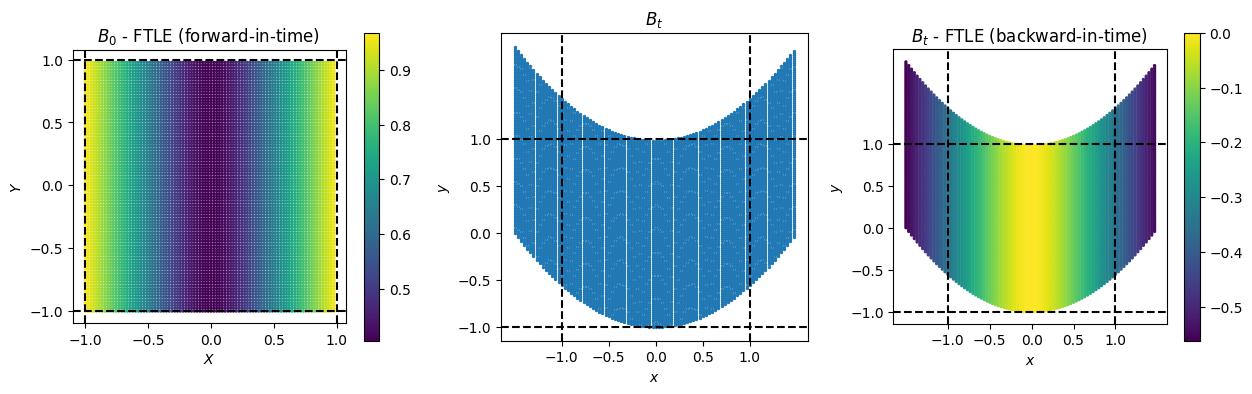

In [35]:
x, y, phi_title, c_fit, c_bit = flow_map(X, Y, 'parab', a=1.5, b=1)
# x, y, phi_title, c_fit, c_bit = flow_map(X, Y, 'spiral1', a=0.1)
# c_bit = -c_bit if c_bit is not None else None

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_cm(
    x=X, y=Y, s=2., c=c_fit,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (forward-in-time) ",
)


plt.subplot(1, 3, 2)
# plot_cm(x=x, y=y, s=2., title=r'$B_t = \chi_t(\mathcal{B}) = %s \ni \varphi: B_0 \rightarrow B_t$' % phi_title)
plot_cm(
    x=x, y=y, s=2.,
    title=r"$B_t$"#r'$B_t = \chi_t(\mathcal{B}) = %s \ni \varphi: B_0 \rightarrow B_t$' % phi_title,
)

plt.subplot(1, 3, 3)
plot_cm(
    x=x, y=y, s=2., c=c_bit,
    title=r"$B_t$ - FTLE (backward-in-time) ",
)

### Test FTLE - PySPH

In [36]:
ftle_ob = FTLyapunovExponent.from_example(dim=2, nx=40, flow_type='parabolic')
# ftle_ob = FTLyapunovExponent.from_example(dim=2, nx=40, flow_type='spiral')

#### FIT

In [37]:
# Time forward
t0 = time.time()
ftle_fit_res = ftle_ob.compute(ftle_type='forward', mode='mpi')
t1 = time.time()
print(f"Computed forward FTLE in {t1-t0} seconds")
ftle_fit_res

Computed forward FTLE in 19.02528142929077 seconds


array([0.52859034, 0.52956123, 0.53072688, ..., 0.69703329, 0.70401263,
       0.71024355])

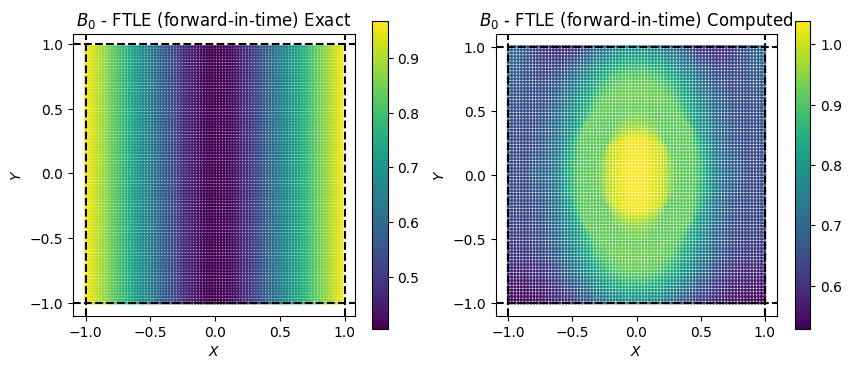

In [38]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_cm(
    x=X, y=Y, s=2., c=c_fit,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (forward-in-time) Exact",
)

plt.subplot(1, 2, 2)
X_comp = ftle_ob.pa_0.get('x')
Y_comp = ftle_ob.pa_0.get('y')
c_fit_comp = ftle_fit_res
plot_cm(
    x=X_comp, y=Y_comp, c=c_fit_comp, s=2,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (forward-in-time) Computed",
)

#### BIT

In [39]:
t0 = time.time()
ftle_bit_res = ftle_ob.compute(ftle_type='backward', mode="mpi")
t1 = time.time()
print(f"Computed backward FTLE in {t1-t0} seconds")
ftle_bit_res

Computed backward FTLE in 18.081437349319458 seconds


array([0.33880434, 0.33624961, 0.33429414, ..., 0.02925853, 0.02063055,
       0.01234712])

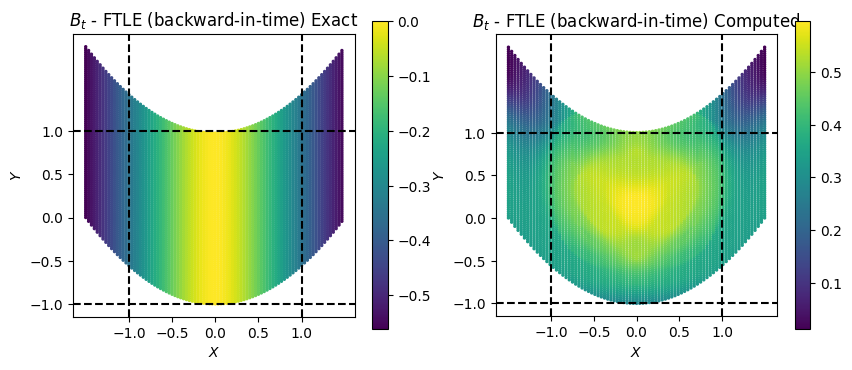

In [40]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_cm(
    x=x, y=y, s=2., c=c_bit,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_t$ - FTLE (backward-in-time) Exact",
)

plt.subplot(1, 2, 2)
x_comp = ftle_ob.pa_f.get('x')
y_comp = ftle_ob.pa_f.get('y')
c_bit_comp = ftle_bit_res
plot_cm(
    x=x_comp, y=y_comp, s=2, c=c_bit_comp,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_t$ - FTLE (backward-in-time) Computed",
)

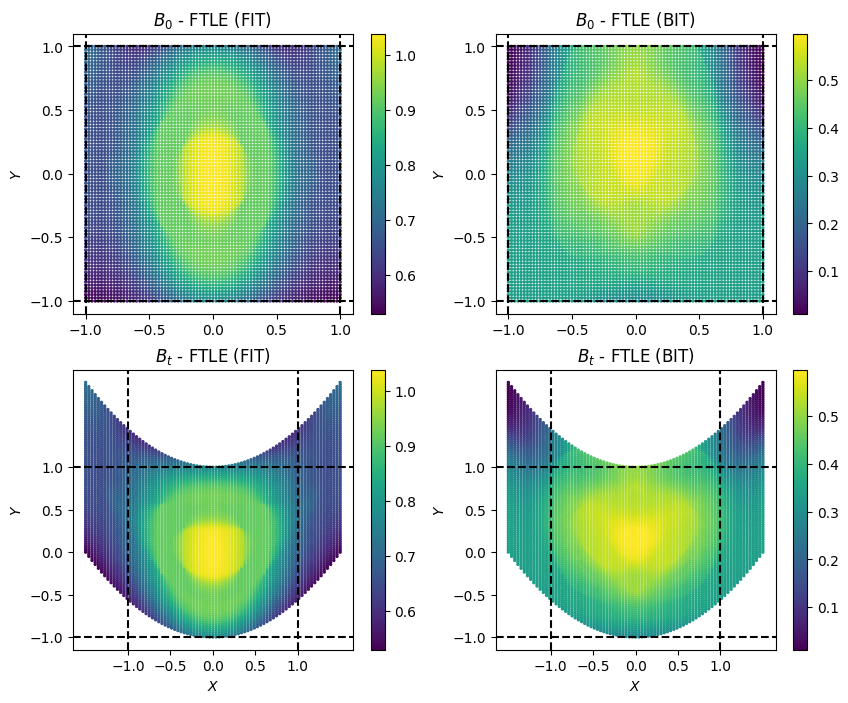

In [41]:
plt.figure(figsize=(10, 8))

X_comp = ftle_ob.pa_0.get('x')
Y_comp = ftle_ob.pa_0.get('y')
c_fit_comp = ftle_fit_res

x_comp = ftle_ob.pa_f.get('x')
y_comp = ftle_ob.pa_f.get('y')
c_bit_comp = ftle_bit_res

plt.subplot(2, 2, 1)
plot_cm(
    x=X_comp, y=Y_comp, c=c_fit_comp, s=2,
    xlabel='', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (FIT)",
)

plt.subplot(2, 2, 2)
plot_cm(
    x=X_comp, y=Y_comp, c=c_bit_comp, s=2,
    xlabel='', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (BIT)",
)

plt.subplot(2, 2, 3)
plot_cm(
    x=x_comp, y=y_comp, s=2, c=c_fit_comp,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_t$ - FTLE (FIT)",
)

plt.subplot(2, 2, 4)
plot_cm(
    x=x_comp, y=y_comp, s=2, c=c_bit_comp,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_t$ - FTLE (BIT)",
)
    

### Matrix Multiplication

In [ ]:
import numpy as np

In [ ]:
# Create a 3X3 array from 0 to 8
a = np.arange(4).reshape(2,2)
a = np.arange(9).reshape(3,3)
a_flat = a.flatten()
a_flat, a

In [ ]:
# Multiply a transpose of a with a
b_expected = np.dot(a.T, a)
a.T, a, b_expected

In [ ]:
# Multiply transpose of a with a and store in b
b_flat = np.zeros(9)
for i in range(3):
    for j in range(3):
        b_flat[3*i + j] = 0.
        for k in range(3):
            b_flat[3*i + j] += a_flat[3*k + i] * a_flat[3*k + j]

In [ ]:
print(b_flat.reshape(3,3))

### Eigen Values

In [ ]:
import numpy as np
from pysph.base import linalg3

In [ ]:
a = np.ones((3,3), dtype=float)
a = np.diag((2., 2., 1.))
a = np.arange(9, dtype=np.float64).reshape(3,3)

# Generate rabdom positive definite matrix
dim = 2
a = np.random.rand(dim, dim)
a = np.dot(a, a.T)

print(f"{a = }")
eigs_np = np.linalg.eigvals(a)
if dim == 2:
    # Append zero eigenvalue
    eigs_np = np.append(eigs_np, 0.)
eigs_np = np.sort(eigs_np)
print(f"{eigs_np = }")

# Add zero row and column
if dim  == 2:
    a = np.pad(a, ((0, 1), (0, 1)), 'constant', constant_values=0.)
# print(f"{a = }")
# # raise SystemExit

eigs_pysph = linalg3.py_get_eigenvalues(a)
eigs_pysph.sort()
print(f"{eigs_pysph = }")


err = np.max(np.abs(eigs_np - eigs_pysph))
print(f"{err = }")


In [ ]:
%timeit np.sort(np.linalg.eigvals(a))

In [ ]:
%timeit linalg3.py_get_eigenvalues(a).sort()

### Test FTLE

In [ ]:
from pysph.base.utils import get_particle_array
from pysph.sph.acceleration_eval import AccelerationEval
from pysph.base.kernels import CubicSpline
from pysph.base.nnps import LinkedListNNPS as NNPS
from pysph.sph.sph_compiler import SPHCompiler
from pysph.sph.equation import Equation, Group

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class FindTotalMass(Equation):
    def initialize(self, d_idx, d_m, d_total_mass):
        # FIXME: This is stupid and should be fixed if we add a separate
        # initialize_once function or so.
        d_total_mass[0] = 0.0

    def post_loop(self, d_idx, d_m, d_total_mass):
        d_total_mass[0] += d_m[d_idx]

In [ ]:
def _make_accel_eval(pa, dim, equations, cache_nnps=False):
    arrays = [pa]
    kernel = CubicSpline(dim=dim)
    a_eval = AccelerationEval(
        particle_arrays=arrays, equations=equations, kernel=kernel
    )
    comp = SPHCompiler(a_eval, integrator=None)
    comp.compile()
    nnps = NNPS(dim=kernel.dim, particles=arrays, cache=cache_nnps)
    nnps.update()
    a_eval.set_nnps(nnps)
    return a_eval

In [ ]:
dim = 1
n = 10
dx = 1.0 / (n - 1)
x = np.linspace(0, 1, n)
m = np.ones_like(x)
h = np.ones_like(x) * dx * 1.05
pa = get_particle_array(name='fluid', x=x, h=h, m=m)
pa.add_constant('total_mass', 0.0)

equations = [FindTotalMass(dest='fluid', sources=['fluid'])]

In [ ]:
a_eval = _make_accel_eval(pa=pa, dim=dim, equations=equations)
print(pa.total_mass)

In [ ]:
a_eval.compute(0.1, 0.1)
print(pa.total_mass)

#### Test deformation gradient equation

In [ ]:
def print_prop_with_stride(prop, stride, shape):
    N = len(prop)
    for i in range(N//stride):
        print(prop[i*stride:(i+1)*stride].reshape(shape))

In [ ]:
dim = 2
n = 5
dx = 1.0 / (n - 1)
x = y = np.linspace(0, 1, n)
z = np.zeros_like(x)
m = np.ones_like(x)
h = np.ones_like(x) * dx * 1.05
x_prime = np.exp(-x)
y_prime = np.exp(-y)
z_prime = np.exp(-z)

pa = get_particle_array(
    name='fluid', x=x, h=h, m=m,
    x_prime=x_prime, y_prime=x_prime, z_prime=x_prime
)

# Ensure properties are present
props = {
    'deform_grad': 9,
    'm_mat': 9,
    'ftle': 1,
}
for prop in props.keys():
    if prop not in pa.properties:
        pa.add_property(prop, stride=props[prop])

In [ ]:
show_3d = 0
for i in range(n):
    if not show_3d:
        t = f"({x[i]:.2f}, {y[i]:.2f}) --> "
        t += f"({x_prime[i]:.2f}, {y_prime[i]:.2f})"
    else:
        t = f"({x[i]:.2f}, {y[i]:.2f}, {z[i]:.2f}) --> "
        t += f"({x_prime[i]:.2f}, {y_prime[i]:.2f}, {z_prime[i]:.2f})"
    print(t)

In [ ]:
plt.scatter(x, y)
plt.scatter(x_prime, y_prime)
# Annotate the points with their indices
plt.quiver(x, y, x_prime - x, y_prime - y)
for i in range(n):
    eps = 0.02
    plt.annotate(i, (x[i] + eps, y[i]))
    eps = 0.02
    plt.annotate(i, (x_prime[i], y_prime[i] + eps))

In [ ]:
from compyle.api import declare
class DeformationGradientEquation(Equation):
    def initialize(self, d_idx, d_deform_grad):
        i9, i = declare('int', 2)
        i9 = 9*d_idx

        for i in range(9):
            d_deform_grad[i9 + i] = 0.0

    def loop(
        self, d_idx, s_idx, d_deform_grad, d_x, d_y, d_z, DWIJ,
        s_x_prime, s_y_prime, s_z_prime, s_m, s_rho
    ):
        # Volume
        Vj = s_m[s_idx]/s_rho[s_idx]
        x_prime_ij = declare('matrix(3)')
        x_prime_ij[0] = s_x_prime[s_idx] - d_x[d_idx]
        x_prime_ij[1] = s_y_prime[s_idx] - d_y[d_idx]
        x_prime_ij[2] = s_z_prime[s_idx] - d_z[d_idx]

        i9, i, j = declare('int', 3)
        i9 = 9*d_idx

        print(x_prime_ij)

        # Tensor product of x_prime_ij and DWIJ
        for i in range(3):
            for j in range(3):
                d_deform_grad[i9 + 3*i + j] += x_prime_ij[i]*DWIJ[j]*Vj

In [ ]:
from pysph.sph.basic_equations import SummationDensity
from pysph.sph.wc.kernel_correction import (
    GradientCorrectionPreStep, GradientCorrection,
)
pa_name = 'fluid'
equations = [
    Group(
        equations=[
            SummationDensity(dest=pa_name, sources=[pa_name]),
        ], real=False
    ),
    Group(
        equations=[
            GradientCorrectionPreStep(
                dest=pa_name, sources=[pa_name], dim=dim
            )
        ], real=False
    ),
    Group(
        equations=[
            GradientCorrection(
                dest=pa_name, sources=[pa_name], dim=dim
            ),
            DeformationGradientEquation(
                dest=pa_name, sources=[pa_name]
            ),
        ], real=True
    ),
]

In [ ]:
print_prop_with_stride(pa.deform_grad, 9, (3, 3))

In [ ]:
a_eval = _make_accel_eval(pa=pa, dim=dim, equations=equations)

In [ ]:
a_eval.compute(0.1, 0.1)

In [ ]:
print_prop_with_stride(pa.deform_grad, 9, (3, 3))

In [ ]:
pa.x, pa.x_prime